# LowLou SPINN

In [ ]:
from setproctitle import setproctitle

setproctitle("LowLou SPINN")

In [ ]:
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"

In [ ]:
from zpinn.pinn_nf2_cleanup import create_coordinates
from zpinn.spinn_cleanup_new import SPINN3d, generate_train_data, apply_model_spinn, update_model

In [ ]:
import jax 
import jax.numpy as jnp
import optax
import numpy as np 
import matplotlib.pyplot as plt
import time 
import pickle
from tqdm import trange

<matplotlib.image.AxesImage>

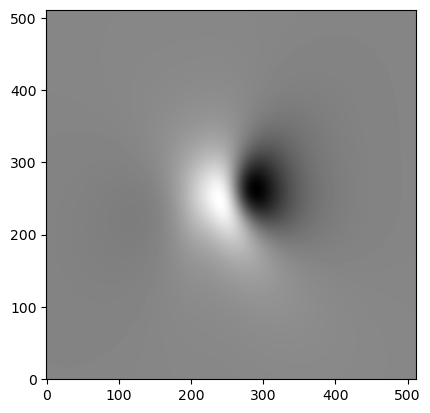

In [ ]:
input_path = '01_input/lowlou_512512512/'
bottom_npy_path = os.path.join(input_path, 'b_bottom.npy')

with open(bottom_npy_path, 'rb') as f:
        b_bottom = np.load(f)

plt.imshow(b_bottom[:, :, 2].transpose(), origin='lower', cmap='gray')

In [ ]:
output_path = '02_output/lowlou_512512512/SPINN'
os.makedirs(output_path, exist_ok=True)

Nx, Ny, _ = b_bottom.shape 
Nz = 512

b_norm = 100

In [ ]:
boundary_path = os.path.join(output_path, 'boundary')
os.makedirs(boundary_path, exist_ok=True)

boundary_npy_path = os.path.join(boundary_path, 'boundary_data.npy')
boundary_stride_npy_path = os.path.join(boundary_path, 'boundary_stride_data.npy')

In [ ]:
epochs = 10000
log_iter = 1000

features = 256
n_layers = 8 
feat_sizes = tuple([features for _ in range(n_layers)]) 
r = 128 
out_dim = 3 

lr = 5e-4

## Create boundary data

### Stride

In [ ]:
from astropy.nddata import block_reduce
from zpinn.pinn_nf2_old import get_potential_boundary

In [ ]:
potential_strides = 4
b_bottom_reduce = block_reduce(b_bottom, (potential_strides, potential_strides, 1), func=np.mean)
height = Nz // potential_strides

pf_batch_size = int(1024 * 512 ** 2 / np.prod(b_bottom_reduce.shape[:2]))
coords, fields = get_potential_boundary(b_bottom_reduce[:, :, 2], height, batch_size=pf_batch_size)

bp_top = fields[0]
bp_lateral_3 = fields[1]
bp_lateral_4 = fields[2]
bp_lateral_1 = fields[3]
bp_lateral_2 = fields[4]

b_bottom = b_bottom / b_norm
bp_top = bp_top / b_norm
bp_lateral_1 = bp_lateral_1 / b_norm
bp_lateral_2 = bp_lateral_2 / b_norm
bp_lateral_3 = bp_lateral_3 / b_norm 
bp_lateral_4 = bp_lateral_4 / b_norm

boundary_data = (b_bottom, bp_top, bp_lateral_1, bp_lateral_2, bp_lateral_3, bp_lateral_4)

with open(boundary_stride_npy_path, "wb") as f:
    pickle.dump(boundary_data, f)

Potential Boundary:   0%|          | 0/15 [00:00<?, ?it/s]

Potential Boundary: 100%|██████████| 15/15 [00:02<00:00,  6.74it/s]


### no stride

In [ ]:
from zpinn.create_pot import get_potential_boundary

In [ ]:
coords, fields = get_potential_boundary(b_bottom[:, :, 2], Nz)

bp_top = fields[0]
bp_lateral_3 = fields[1]
bp_lateral_4 = fields[2]
bp_lateral_1 = fields[3]
bp_lateral_2 = fields[4]

b_bottom = b_bottom / b_norm
bp_top = bp_top / b_norm
bp_lateral_1 = bp_lateral_1 / b_norm
bp_lateral_2 = bp_lateral_2 / b_norm
bp_lateral_3 = bp_lateral_3 / b_norm 
bp_lateral_4 = bp_lateral_4 / b_norm

boundary_data = (b_bottom, bp_top, bp_lateral_1, bp_lateral_2, bp_lateral_3, bp_lateral_4)

with open(boundary_npy_path, "wb") as f:
    pickle.dump(boundary_data, f)

Potential Field: 100%|██████████| 1920/1920 [04:44<00:00,  6.75it/s]


## SPINN

In [ ]:
with open(boundary_npy_path, 'rb') as f:
        boundary_data = pickle.load(f)

In [ ]:
seed = 111
key = jax.random.PRNGKey(seed)
key, subkey = jax.random.split(key, 2)

In [ ]:
model = SPINN3d(feat_sizes, r, out_dim, pos_enc=0, mlp='modified_mlp')
params = model.init(
            subkey,
            jnp.ones((Nx, 1)),
            jnp.ones((Ny, 1)),
            jnp.ones((Nz, 1))
        )
apply_fn = jax.jit(model.apply)
optim = optax.adam(learning_rate=lr)
state = optim.init(params)

In [ ]:
params_path = os.path.join(output_path, "params_0.pickle")
with open(params_path, "wb") as f:
    pickle.dump(params, f)

In [ ]:
key, subkey = jax.random.split(key, 2)
train_data = generate_train_data(Nx, Ny, Nz, key)
train_boundary_data = [train_data, boundary_data]

In [ ]:
losses = []

In [ ]:
loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
losses.append(loss.item())
params, state = update_model(optim, gradient, params, state)

In [ ]:
start = time.time()
for e in trange(1, epochs + 1):
    
    # if e % 300 == 0:
    #     # sample new input data
    #     key, subkey = jax.random.split(key, 2)
    #     train_data = generate_train_data(nx, ny, nz, subkey)

    loss, gradient = apply_model_spinn(apply_fn, params, train_boundary_data)
    losses.append(loss.item())
    params, state = update_model(optim, gradient, params, state)
    
    if e % log_iter == 0 or e == 1:
        print(f'Epoch: {e}/{epochs} --> total loss: {loss:.8f}')
        params_path = os.path.join(output_path, f"params_{e}.pickle")
        with open(params_path, "wb") as f:
            pickle.dump(params, f)
np.save(os.path.join(output_path, 'losses.npy'), losses)
runtime = time.time() - start
print(f'Runtime --> total: {runtime:.2f}sec ({(runtime/(epochs-1)*1000):.2f}ms/iter.)')

  0%|          | 1/10000 [00:00<55:49,  2.98it/s]

Epoch: 1/10000 --> total loss: 0.21105222


 10%|█         | 1000/10000 [05:14<47:55,  3.13it/s]

Epoch: 1000/10000 --> total loss: 0.00202348


 10%|█         | 1015/10000 [05:19<47:05,  3.18it/s]


KeyboardInterrupt: 

In [ ]:
with open(os.path.join(output_path, 'losses.npy'), "rb") as f:
        losses = np.load(f)

Text(0, 0.5, 'Loss')

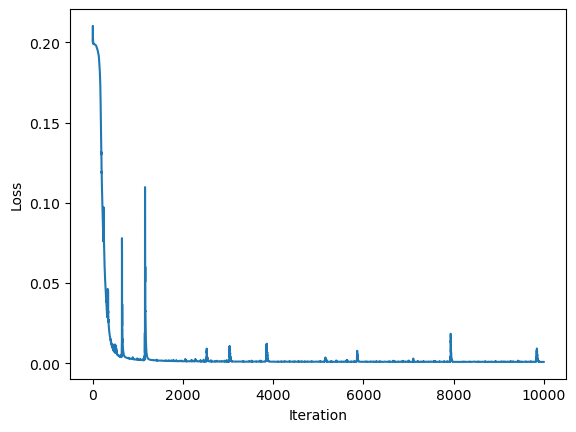

In [ ]:
plt.plot(losses)
plt.xlabel('Iteration')
plt.ylabel('Loss')

## Viz

In [ ]:
import pyvista as pv
from zpinn.pinn_nf2_visualization import draw_grid
from zpinn.spinn_cleanup import load_spinn_mag

In [ ]:
pv.start_xvfb()
pv.global_theme.trame.server_proxy_enabled = True
pv.set_jupyter_backend('static')

In [ ]:
eval_path = '03_eval/lowlou_256256256/SPINN'
os.makedirs(eval_path, exist_ok=True)
vtk_path = os.path.join(eval_path, f'B_spinn_{epochs}.vtk')

### vtk

In [ ]:
def ctr_mesh(vtk_path, param_path, Nx, Ny, Nz, b_norm):
    with open(param_path,"rb") as f:
        params = pickle.load(f)

    B = load_spinn_mag(param_path, Nx, Ny, Nz, b_norm)

    Bx = B[..., 0]
    By = B[..., 1]
    Bz = B[..., 2]

    co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
    co_coords = create_coordinates(co_bounds).reshape(-1, 3)
    co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
    x = co_coord[..., 0]
    y = co_coord[..., 1]
    z = co_coord[..., 2]
    mesh = pv.StructuredGrid(x, y, z)
    vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
    mesh['B'] = vectors
    mesh.active_vectors_name = 'B'
    magnitude = np.linalg.norm(vectors, axis=-1)
    mesh['mag'] = magnitude
    mesh.active_scalars_name = 'mag'
    mesh.save(vtk_path)

In [ ]:
epo = 1000
param_path = os.path.join(output_path, f"params_{epo}.pickle")
vtk_paths = os.path.join(eval_path, f'B_spinn_{epo}.vtk')
ctr_mesh(vtk_paths, param_path, Nx, Ny, Nz, b_norm)
print(epo)

1000


In [ ]:
iterations = np.arange(0, epochs+1, log_iter)

for epo in iterations:
    param_path = os.path.join(output_path, f"params_{epo}.pickle")
    vtk_paths = os.path.join(eval_path, f'B_spinn_{epo}.vtk')
    ctr_mesh(vtk_paths, param_path, Nx, Ny, Nz, b_norm)
    print(epo)

In [ ]:
# param_path = os.path.join(output_path, f"params_{epochs}.pickle")

# with open(param_path,"rb") as f:
#     params = pickle.load(f)

# B = load_spinn_mag(param_path, Nx, Ny, Nz, b_norm)

# Bx = B[..., 0]
# By = B[..., 1]
# Bz = B[..., 2]

# co_bounds = (0, Nx-1, 0, Ny-1, 0, Nz-1)
# co_coords = create_coordinates(co_bounds).reshape(-1, 3)
# co_coord = co_coords.reshape(Nx, Ny, Nz, 3)
# x = co_coord[..., 0]
# y = co_coord[..., 1]
# z = co_coord[..., 2]
# mesh = pv.StructuredGrid(x, y, z)
# vectors = np.stack([Bx, By, Bz], axis=-1).transpose(2, 1, 0, 3).reshape(-1, 3)
# mesh['B'] = vectors
# mesh.active_vectors_name = 'B'
# magnitude = np.linalg.norm(vectors, axis=-1)
# mesh['mag'] = magnitude
# mesh.active_scalars_name = 'mag'

# mesh

StructuredGrid (0x7f91b05a8e20)
  N Cells:      2048383
  N Points:     2097152
  X Bounds:     0.000e+00, 1.270e+02
  Y Bounds:     0.000e+00, 1.270e+02
  Z Bounds:     0.000e+00, 1.270e+02
  Dimensions:   128, 128, 128
  N Arrays:     2

### load

In [ ]:
B_spinn_mesh = pv.read(vtk_path)

In [ ]:
B_spinn_grid = draw_grid(B_spinn_mesh)

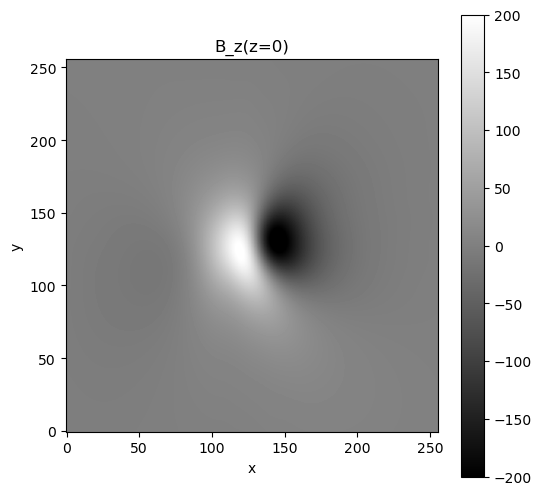

In [ ]:
B_spinn_grid.plt_Bz_imshow(z=0, vmin=-200, vmax=200)

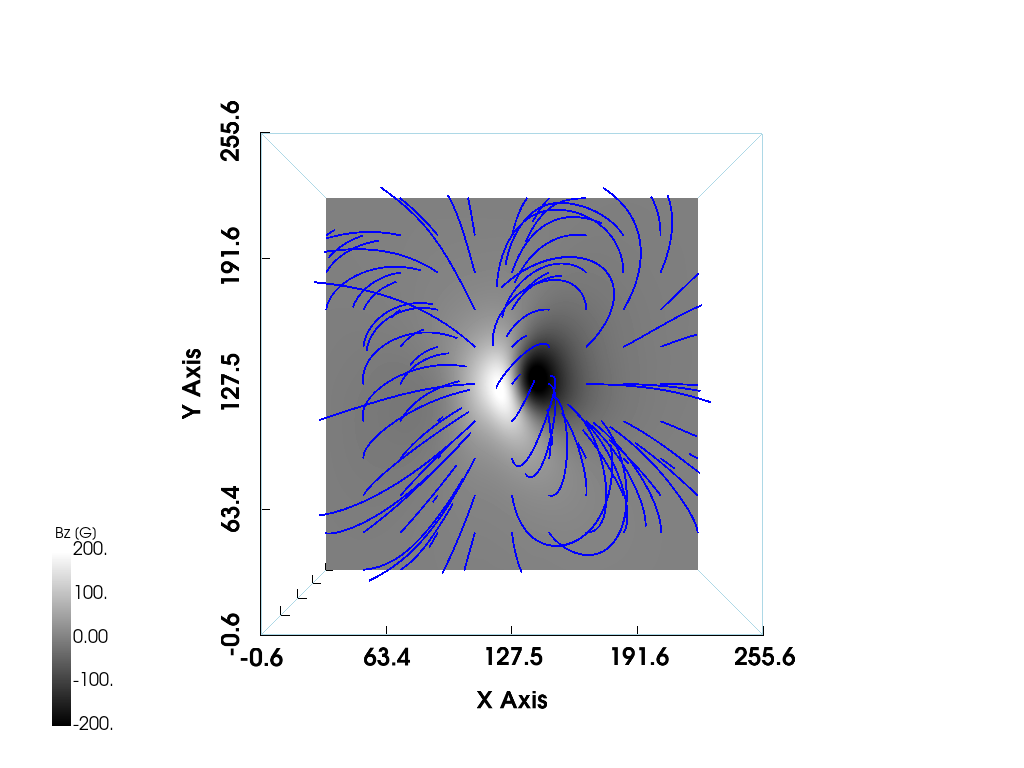

In [ ]:
B_spinn_grid.pv_streamline_Bz(camera_position='xy', i_resolution=10, j_resolution=10, vmin=-200, vmax=200)